In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
from torch_geometric.data import Data
import torch.optim as optim
from ogb.graphproppred.mol_encoder import AtomEncoder


In [31]:
from torch_geometric.datasets import MoleculeNet
from torch_geometric.loader import DataLoader

# Load BBBP dataset (Molecular graphs)
dataset = MoleculeNet(root="data", name="BBBP")

# Split dataset into train, validation, and test sets
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create PyG DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for batch in train_loader:
    print(batch)
    break  # Print one batch and exit loop


DataBatch(x=[1524, 9], edge_index=[2, 3264], edge_attr=[3264, 3], smiles=[64], y=[64, 1], batch=[1524], ptr=[65])


In [32]:
# from scaffold_split import scaffold_split
# from torch_geometric.data import DataLoader

# # Extract SMILES from dataset
# smiles_list = [data.smiles for data in dataset]

# # Split indices
# train_idx, val_idx, test_idx = scaffold_split(smiles_list)

# # Create splits
# train_dataset = [dataset[i] for i in train_idx]
# val_dataset = [dataset[i] for i in val_idx]
# test_dataset = [dataset[i] for i in test_idx]

# # Loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32)
# test_loader = DataLoader(test_dataset, batch_size=32)


In [33]:
from collections import Counter
val_labels = [data.y.item() for data in val_dataset]
print(Counter(val_labels))


Counter({1.0: 319, 0.0: 88})


In [34]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Embedding
from torch_geometric.nn import GCNConv, global_mean_pool


class EdgeAwareGCN(torch.nn.Module):
    def __init__(self, in_channels, edge_dim, hidden_dim=64, num_classes=1):
        super(EdgeAwareGCN, self).__init__()
        self.atom_encoder = AtomEncoder(emb_dim=hidden_dim)

        # GCN Layers (with edge weight)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = torch.nn.Dropout(p=0.3)
        # Fully Connected Layer for Graph Classification
        self.fc = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.atom_encoder(x)  # Encode node features into embeddings

        # Use edge_attr as edge weights (ensure it's 1D)
        edge_weight = edge_attr.mean(dim=1) if edge_attr is not None else None

        x = self.conv1(x, edge_index, edge_weight)
        

        x = self.dropout(F.relu(x))

        x = self.conv2(x, edge_index, edge_weight)
        x = self.dropout(F.relu(x))

        x = self.conv3(x, edge_index, edge_weight)
        x = self.dropout(F.relu(x))

        # Aggregate node features into a graph-level representation
        x = global_mean_pool(x, batch)

        # Classification layer
        x = self.fc(x)
        return torch.sigmoid(x)  # Sigmoid for binary classification




Epoch 1, Train Loss: 0.5576, Train Accuracy: 0.7603 | Val Loss: 0.5102, Val Accuracy: 0.7838, Val AUROC: 0.7620
Epoch 2, Train Loss: 0.5333, Train Accuracy: 0.7603 | Val Loss: 0.4940, Val Accuracy: 0.7838, Val AUROC: 0.7615
Epoch 3, Train Loss: 0.5182, Train Accuracy: 0.7603 | Val Loss: 0.4847, Val Accuracy: 0.7838, Val AUROC: 0.7879
Epoch 4, Train Loss: 0.5084, Train Accuracy: 0.7603 | Val Loss: 0.4595, Val Accuracy: 0.7838, Val AUROC: 0.7947
Epoch 5, Train Loss: 0.4739, Train Accuracy: 0.7609 | Val Loss: 0.4388, Val Accuracy: 0.7887, Val AUROC: 0.7938
Epoch 6, Train Loss: 0.4540, Train Accuracy: 0.7909 | Val Loss: 0.4247, Val Accuracy: 0.8329, Val AUROC: 0.8080
Epoch 7, Train Loss: 0.4476, Train Accuracy: 0.7983 | Val Loss: 0.4277, Val Accuracy: 0.8329, Val AUROC: 0.7982
Epoch 8, Train Loss: 0.4361, Train Accuracy: 0.8105 | Val Loss: 0.4607, Val Accuracy: 0.8108, Val AUROC: 0.8167
Epoch 9, Train Loss: 0.4434, Train Accuracy: 0.8032 | Val Loss: 0.4334, Val Accuracy: 0.8084, Val AUROC:

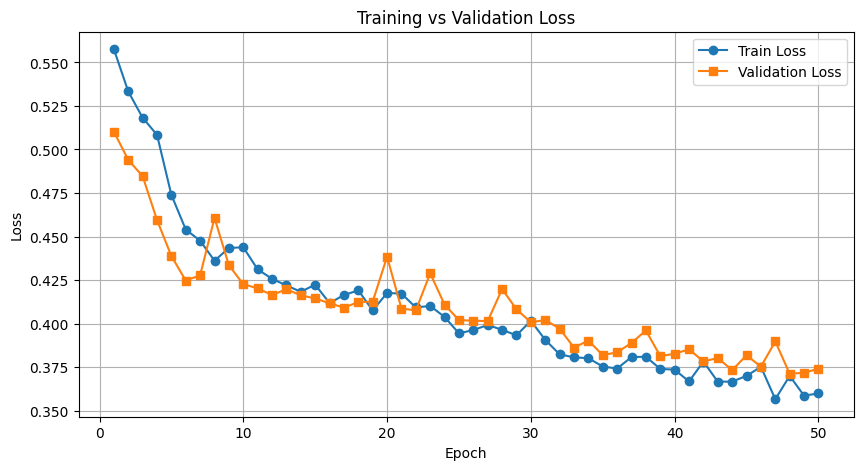

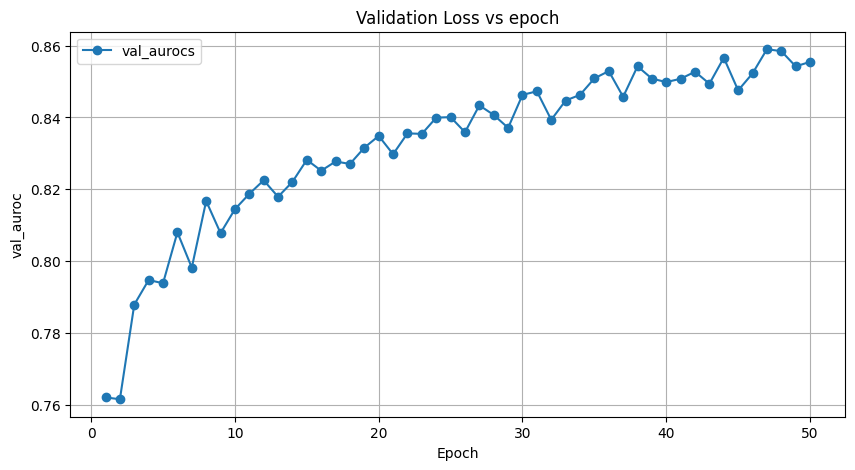

In [35]:

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize Model
model = EdgeAwareGCN(in_channels=dataset.num_node_features, edge_dim=dataset.num_edge_features).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_fn = torch.nn.BCELoss()  # Binary classification

# Training Function
def train():
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Convert node features to float
        # x = batch.x.float()

        # Ensure edge attributes exist & convert to float
        edge_attr = batch.edge_attr.float() if batch.edge_attr is not None else None

        # Forward pass
        output = model(batch.x, batch.edge_index, edge_attr, batch.batch)

        # Ensure loss dimensions match
        loss = loss_fn(output.view(-1), batch.y.view(-1).float())

        # Backpropagation
        loss.backward()
        optimizer.step()

         # Accuracy Calculation
        preds = (output.view(-1) > 0.5).float()  # Binary classification threshold at 0.5
        correct += (preds == batch.y.view(-1).float()).sum().item()
        total_samples += batch.y.size(0)

        total_loss += loss.item()
    accuracy = correct / total_samples if total_samples > 0 else 0
    return total_loss / len(train_loader), accuracy  # Keep loss as float

from sklearn.metrics import roc_auc_score

# Validation Function with AUROC
def validate():
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)

            # Convert edge attributes to float
            edge_attr = batch.edge_attr.float() if batch.edge_attr is not None else None

            # Forward pass
            output = model(batch.x, batch.edge_index, edge_attr, batch.batch)

            # Compute loss
            loss = loss_fn(output.view(-1), batch.y.view(-1).float())
            total_loss += loss.item()

            # Store probabilities and labels for AUROC
            all_preds.extend(output.view(-1).cpu().numpy())
            all_labels.extend(batch.y.view(-1).cpu().numpy())

            # Accuracy Calculation
            preds = (output.view(-1) > 0.5).float()
            correct += (preds == batch.y.view(-1).float()).sum().item()
            total_samples += batch.y.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total_samples if total_samples > 0 else 0
    auroc = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) > 1 else float('nan')  # Handle edge case
    return avg_loss, accuracy, auroc


def test():
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)

            # Convert edge attributes to float
            edge_attr = batch.edge_attr.float() if batch.edge_attr is not None else None

            # Forward pass
            output = model(batch.x, batch.edge_index, edge_attr, batch.batch)

            # Compute loss
            loss = loss_fn(output.view(-1), batch.y.view(-1).float())
            total_loss += loss.item()

            # Store probabilities and labels for AUROC
            all_preds.extend(output.view(-1).cpu().numpy())
            all_labels.extend(batch.y.view(-1).cpu().numpy())

            # Accuracy Calculation
            preds = (output.view(-1) > 0.5).float()
            correct += (preds == batch.y.view(-1).float()).sum().item()
            total_samples += batch.y.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total_samples if total_samples > 0 else 0
    auroc = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) > 1 else float('nan')  # Handle edge case
    return avg_loss, accuracy, auroc

import matplotlib.pyplot as plt

# Initialize lists to store training progress
train_losses = []
val_losses = []
val_aurocs = []

# Run Training and Collect Data
num_epochs = 50

for epoch in range(num_epochs):
    loss, accuracy = train()
    val_loss, val_acc, val_auroc = validate()
    
    # Store values
    train_losses.append(loss)
    val_losses.append(val_loss)
    val_aurocs.append(val_auroc)
    
    print(f"Epoch {epoch+1}, Train Loss: {loss:.4f}, Train Accuracy: {accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val AUROC: {val_auroc:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_aurocs, label="val_aurocs" , marker='o')
plt.xlabel("Epoch")
plt.ylabel("val_auroc")
plt.title("Validation Loss vs epoch")
plt.legend()
plt.grid()
plt.show()

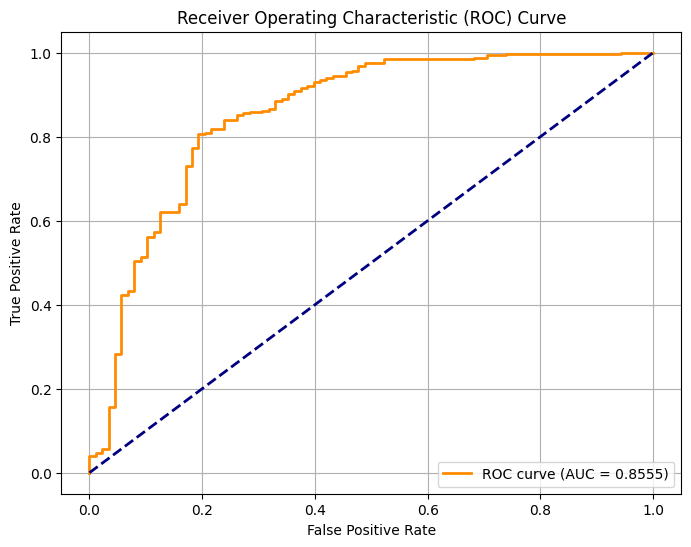

In [36]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to Compute and Plot the ROC Curve
def plot_roc_curve():
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            edge_attr = batch.edge_attr.float() if batch.edge_attr is not None else None
            output = model(batch.x, batch.edge_index, edge_attr, batch.batch)

            # Store probabilities and true labels
            all_preds.extend(output.view(-1).cpu().numpy())  # Model probabilities
            all_labels.extend(batch.y.view(-1).cpu().numpy())  # Ground truth labels

    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Reference line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Call this function after model validation
plot_roc_curve()


### Graph Attention Networks (GAT)

In [37]:
import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


In [53]:
# import torch
# import torch.nn.functional as F
# from torch.nn import Linear
# from torch_geometric.nn import GATConv, global_mean_pool

# class EdgeAwareGAT(torch.nn.Module):
#     def __init__(self, in_channels, edge_dim, hidden_dim=64, heads=4, num_classes=1):
#         super(EdgeAwareGAT, self).__init__()
#         self.atom_encoder = AtomEncoder(emb_dim=hidden_dim)

#         # First GAT Layer with Edge Features
#         self.conv1 = GATConv(hidden_dim, hidden_dim, heads=heads, edge_dim=edge_dim, concat=True)
#         self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, edge_dim=edge_dim, concat=False)
        
#         self.dropout = torch.nn.Dropout(p=0.3)
#         # Fully Connected Layer for Graph Classification
#         self.fc = Linear(hidden_dim, num_classes)

#     def forward(self, x, edge_index, edge_attr, batch):
#         x = self.atom_encoder(x)
#         x = self.conv1(x, edge_index, edge_attr)
#         x = F.elu(x)
#         x = self.dropout(x)
#         x = self.conv2(x, edge_index, edge_attr)
#         x = F.elu(x)
        

#         # Global mean pooling to aggregate node features
#         x = global_mean_pool(x, batch)

#         # Final classification layer
#         x = self.fc(x)
#         return torch.sigmoid(x)

import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GATConv, global_mean_pool

class EdgeAwareGAT(torch.nn.Module):
    def __init__(self, in_channels, edge_dim, hidden_dim=64, heads=4, num_classes=1):
        super(EdgeAwareGAT, self).__init__()
        self.atom_encoder = AtomEncoder(emb_dim=hidden_dim)

        # First GAT layer
        self.conv1 = GATConv(hidden_dim, hidden_dim, heads=heads, edge_dim=edge_dim, concat=True)
        
        # New intermediate GAT layer
        self.conv_mid = GATConv(hidden_dim * heads, hidden_dim, heads=heads, edge_dim=edge_dim, concat=True)
        
        # Second (now third) GAT layer
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, edge_dim=edge_dim, concat=False)
        
        self.dropout = torch.nn.Dropout(p=0.3)

        # Fully Connected Layer for Graph Classification
        self.fc = Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.atom_encoder(x)
        x = self.conv1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv_mid(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index, edge_attr)
        x = F.elu(x)

        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return torch.sigmoid(x)


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # weight for positive class
        self.gamma = gamma  # focusing parameter
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Binary focal loss
        inputs = inputs.view(-1)      # flatten if needed
        targets = targets.view(-1)

        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction="none")
        pt = torch.where(targets == 1, inputs, 1 - inputs)  # pt = p if label == 1 else 1-p

        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss


In [56]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0


c:\Users\prart\anaconda3\envs\GNN\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 0.0365, Train Accuracy: 0.7296 | Val Loss: 0.0349, Val Accuracy: 0.8256, Val AUROC: 0.7846
Epoch 2, Train Loss: 0.0316, Train Accuracy: 0.7664 | Val Loss: 0.0280, Val Accuracy: 0.8305, Val AUROC: 0.8083
Epoch 3, Train Loss: 0.0292, Train Accuracy: 0.8020 | Val Loss: 0.0268, Val Accuracy: 0.8305, Val AUROC: 0.8198
Epoch 4, Train Loss: 0.0270, Train Accuracy: 0.8265 | Val Loss: 0.0267, Val Accuracy: 0.8428, Val AUROC: 0.8223
Epoch 5, Train Loss: 0.0263, Train Accuracy: 0.8357 | Val Loss: 0.0257, Val Accuracy: 0.8428, Val AUROC: 0.8339
Epoch 6, Train Loss: 0.0253, Train Accuracy: 0.8369 | Val Loss: 0.0268, Val Accuracy: 0.8526, Val AUROC: 0.8303
EarlyStopping counter: 1 out of 10
Epoch 7, Train Loss: 0.0257, Train Accuracy: 0.8387 | Val Loss: 0.0269, Val Accuracy: 0.8452, Val AUROC: 0.8260
EarlyStopping counter: 2 out of 10
Epoch 8, Train Loss: 0.0249, Train Accuracy: 0.8394 | Val Loss: 0.0266, Val Accuracy: 0.8378, Val AUROC: 0.8351
Epoch 9, Train Loss: 0.0247, Train

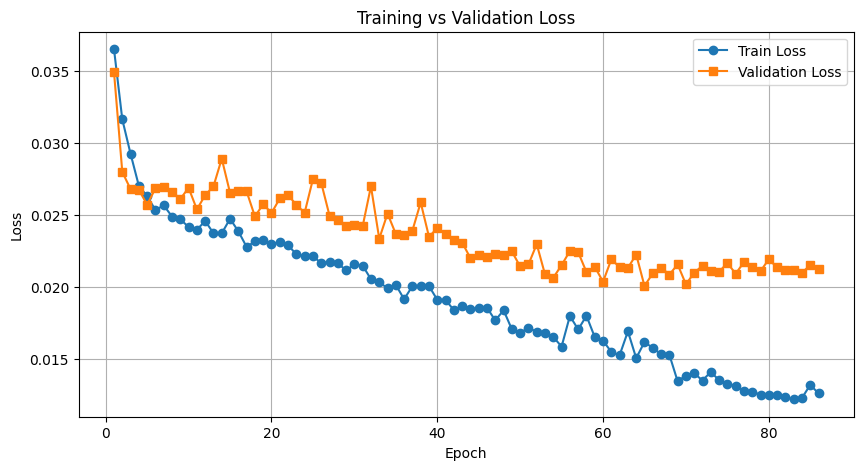

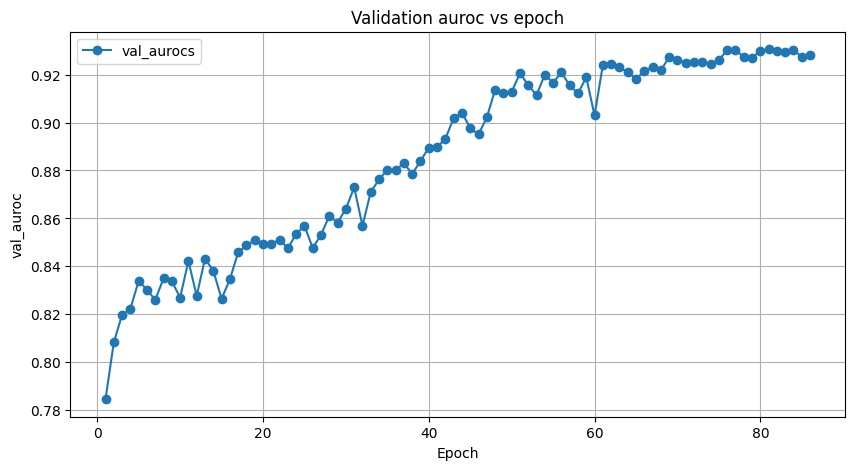

In [62]:

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize Model
model = EdgeAwareGAT(in_channels=dataset.num_node_features, edge_dim=dataset.num_edge_features).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
                    #    , weight_decay=1e-4)
# loss_fn = torch.nn.BCELoss()  # Binary classification
loss_fn = FocalLoss(alpha=0.25, gamma=2.0)
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(
    optimizer,               # the optimizer to update
    mode='max',              # because we want to maximize AUROC
    factor=0.5,              # reduce LR by half
    patience=5,              # wait 5 epochs before reducing LR
    verbose=True,            # prints LR updates
    min_lr=1e-6              # prevent LR from becoming too small
)

# Training Function
def train():
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Convert node features to float
        # x = batch.x.float()

        # Ensure edge attributes exist & convert to float
        edge_attr = batch.edge_attr.float() if batch.edge_attr is not None else None

        # Forward pass
        output = model(batch.x, batch.edge_index, edge_attr, batch.batch)

        # Ensure loss dimensions match
        loss = loss_fn(output.view(-1), batch.y.view(-1).float())

        # Backpropagation
        loss.backward()
        optimizer.step()

         # Accuracy Calculation
        preds = (output.view(-1) > 0.5).float()  # Binary classification threshold at 0.5
        correct += (preds == batch.y.view(-1).float()).sum().item()
        total_samples += batch.y.size(0)

        total_loss += loss.item()
    accuracy = correct / total_samples if total_samples > 0 else 0
    return total_loss / len(train_loader), accuracy  # Keep loss as float

from sklearn.metrics import roc_auc_score

# Validation Function with AUROC
def validate():
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)

            # Convert edge attributes to float
            edge_attr = batch.edge_attr.float() if batch.edge_attr is not None else None

            # Forward pass
            output = model(batch.x, batch.edge_index, edge_attr, batch.batch)

            # Compute loss
            loss = loss_fn(output.view(-1), batch.y.view(-1).float())
            total_loss += loss.item()

            # Store probabilities and labels for AUROC
            all_preds.extend(output.view(-1).cpu().numpy())
            all_labels.extend(batch.y.view(-1).cpu().numpy())

            # Accuracy Calculation
            preds = (output.view(-1) > 0.5).float()
            correct += (preds == batch.y.view(-1).float()).sum().item()
            total_samples += batch.y.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct / total_samples if total_samples > 0 else 0
    auroc = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) > 1 else float('nan')  # Handle edge case


    return avg_loss, accuracy, auroc


def test():
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)

            # Convert edge attributes to float
            edge_attr = batch.edge_attr.float() if batch.edge_attr is not None else None

            # Forward pass
            output = model(batch.x, batch.edge_index, edge_attr, batch.batch)

            # Compute loss
            loss = loss_fn(output.view(-1), batch.y.view(-1).float())
            total_loss += loss.item()

            # Store probabilities and labels for AUROC
            all_preds.extend(output.view(-1).cpu().numpy())
            all_labels.extend(batch.y.view(-1).cpu().numpy())

            # Accuracy Calculation
            preds = (output.view(-1) > 0.5).float()
            correct += (preds == batch.y.view(-1).float()).sum().item()
            total_samples += batch.y.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total_samples if total_samples > 0 else 0
    auroc = roc_auc_score(all_labels, all_preds) if len(set(all_labels)) > 1 else float('nan')  # Handle edge case
    return avg_loss, accuracy, auroc

import matplotlib.pyplot as plt

# Initialize lists to store training progress
train_losses = []
val_losses = []
val_aurocs = []

# Run Training and Collect Data
num_epochs = 100
best_auroc = 0.0
early_stopping = EarlyStopping(patience=10, min_delta=0.001)

for epoch in range(num_epochs):
    loss, accuracy = train()
    val_loss, val_acc, val_auroc = validate()
    if val_auroc > best_auroc:
        best_auroc = val_auroc
        torch.save(model.state_dict(), "best_model.pt")

    scheduler.step(val_auroc)

    # Store values
    train_losses.append(loss)
    val_losses.append(val_loss)
    val_aurocs.append(val_auroc)
    
    print(f"Epoch {epoch+1}, Train Loss: {loss:.4f}, Train Accuracy: {accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}, Val AUROC: {val_auroc:.4f}")
    
    early_stopping(val_auroc)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(val_aurocs) + 1), val_aurocs, label="val_aurocs" , marker='o')
plt.xlabel("Epoch")
plt.ylabel("val_auroc")
plt.title("Validation auroc vs epoch")
plt.legend()
plt.grid()
plt.show()

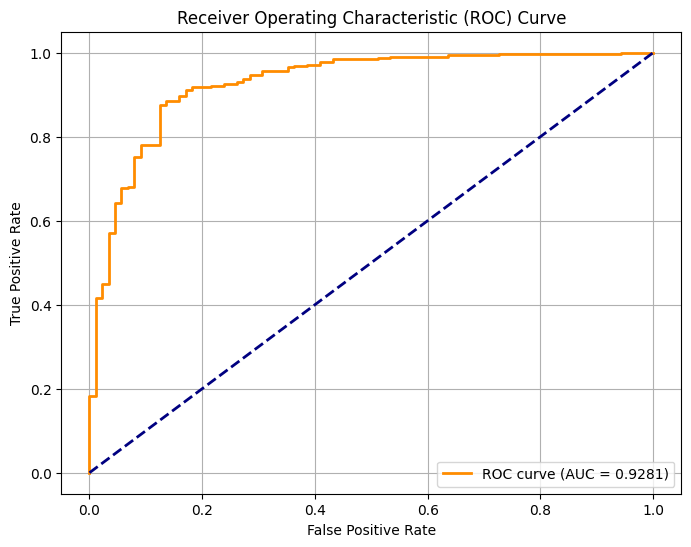

In [63]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Function to Compute and Plot the ROC Curve
def plot_roc_curve():
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            edge_attr = batch.edge_attr.float() if batch.edge_attr is not None else None
            output = model(batch.x, batch.edge_index, edge_attr, batch.batch)

            # Store probabilities and true labels
            all_preds.extend(output.view(-1).cpu().numpy())  # Model probabilities
            all_labels.extend(batch.y.view(-1).cpu().numpy())  # Ground truth labels

    # Compute ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Reference line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Call this function after model validation
plot_roc_curve()
